Step 1: Import Python libraries and define function necessaries for the experiments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.spatial import cKDTree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import make_circles
import warnings
warnings.filterwarnings("ignore")


# function to calculate epsilon-representativeness of a subset.
def find_epsilon(X,y,X_res,y_res):
    epsilon = 0
    classes = np.unique(y)
    for cl in classes:
        A = X_res[y_res==cl]
        if A.shape[0] > 0:
            B = X[y==cl]
            kdtree = cKDTree(A)
            epsilon = max(epsilon,max(kdtree.query(B,p=np.inf)[0]))
    return epsilon

# function to generate a subset
def reduce(X,y,perc,seed):
    X_red, X_valid , y_red, y_valid = train_test_split(X,y,train_size=perc,shuffle=True,random_state=seed) 
    return X_red, y_red

feature_names=["x","y"]
plot_colors = "ryb"
def plot_decision_boundaries_within_data(tree, X, y,titulo):
    
    
    disp = DecisionBoundaryDisplay.from_estimator(
        tree, X, response_method="predict",
        xlabel=feature_names[0], ylabel=feature_names[1],
        alpha=0.5,)
    disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    plt.title(titulo)
    plt.show()

We generate the data and visualize the point cloud.

(200, 2)
(200,)
1    100
0    100
Name: count, dtype: int64


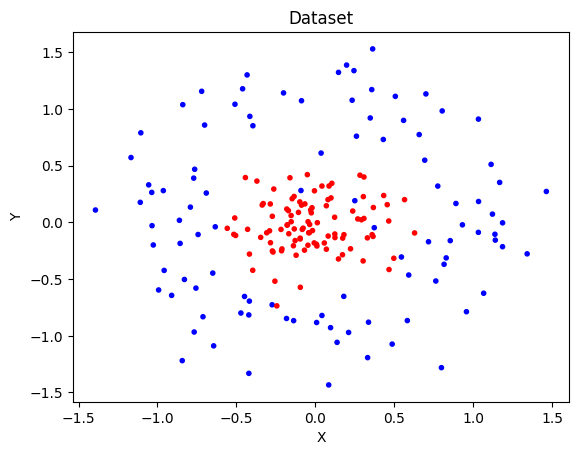

In [2]:
n_samples = 200
factor_noise = 0.05

X, y = make_circles(n_samples=n_samples, factor=factor_noise, noise=0.25,random_state=5)

print(X.shape)
print(y.shape)
print(pd.value_counts(y))
# Visualizar el dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', marker='.')
plt.title('Dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

We split the dataset into training set, which is composed of the 75% of the data, and test set, which is composed with the remaining 25%

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1, shuffle=True, stratify=y)
print(X_train.shape)
print(y_train.shape)
print(pd.value_counts(y_train))
print(X_test.shape)
print(y_test.shape)
print(pd.value_counts(y_test))

(150, 2)
(150,)
0    75
1    75
Name: count, dtype: int64
(50, 2)
(50,)
1    25
0    25
Name: count, dtype: int64


Generate two random subsets, both containing 40% of the training set, and compute their epsilon-representativeness according to training set

In [4]:
perc1=0.4
perc2=0.4
X1,y1 = reduce(X_train,y_train,perc1,1)
print(find_epsilon(X_train,y_train,X1,y1))
X2,y2 = reduce(X_train,y_train,perc2,2)
print(find_epsilon(X_train,y_train,X2,y2))

0.7564158652955097
0.4861426672489569


We create the decision tree(DT) for each set, all of them with the same parameters, train them with their corresponding set and evaluate their accuracy on test set.

In [5]:
treeC = DecisionTreeClassifier(max_depth= 4,)
tree1 = DecisionTreeClassifier(max_depth= 4,)
tree2 = DecisionTreeClassifier(max_depth= 4,)
treeC.fit(X_train, y_train)
tree1.fit(X1, y1)
tree2.fit(X2, y2)
predictedC,predicted1,predicted2 = treeC.predict(X_test),tree1.predict(X_test), tree2.predict(X_test)
cl_repC,cl_rep1,cl_rep2 = classification_report(y_test, predictedC, output_dict=True, zero_division = 0),classification_report(y_test, predicted1, output_dict=True, zero_division = 0),classification_report(y_test, predicted2, output_dict=True, zero_division = 0)
print(f'treeCompleto: Accuracy: {cl_repC["accuracy"]}, F1-S: {cl_repC["macro avg"]["f1-score"]}')
print(f'tree1: Accuracy: {cl_rep1["accuracy"]}, F1-S: {cl_rep1["macro avg"]["f1-score"]}')
print(f'tree2: Accuracy: {cl_rep2["accuracy"]}, F1-S: {cl_rep2["macro avg"]["f1-score"]}')

treeCompleto: Accuracy: 0.84, F1-S: 0.8397435897435898
tree1: Accuracy: 0.94, F1-S: 0.9399759903961584
tree2: Accuracy: 0.9, F1-S: 0.8999599839935974


Visualize decision trees rules

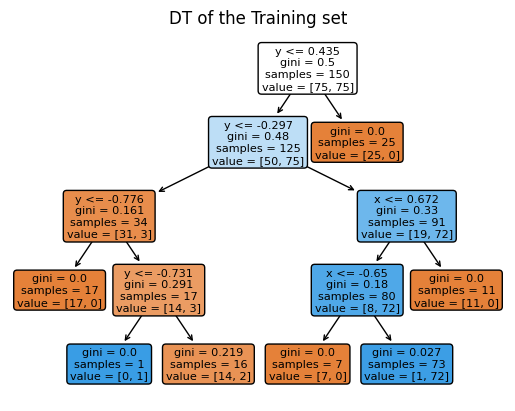

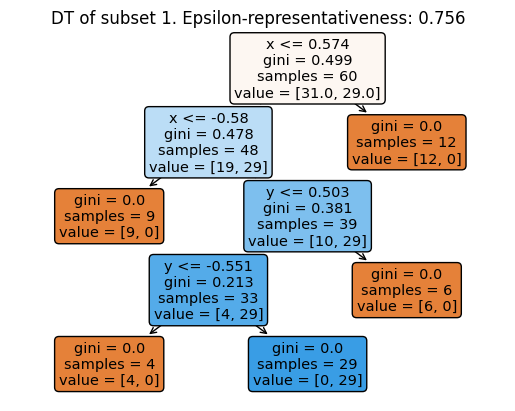

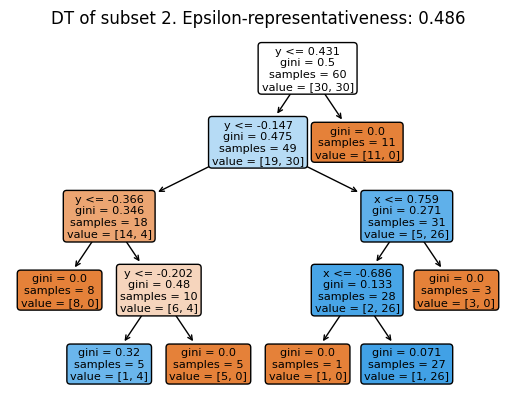

In [6]:
plot_tree(treeC, filled=True, rounded=True,feature_names=["x","y"])
plt.title(f'DT of the Training set')
plt.show()

#plt.subplot(2, 2, 2)
plot_tree(tree1, filled=True, rounded=True,feature_names=["x","y"])
plt.title(f'DT of subset 1. Epsilon-representativeness: {round(find_epsilon(X_train,y_train,X1,y1),3)}')
plt.show()

#plt.subplot(2, 2, 3)
plot_tree(tree2, filled=True, rounded=True,feature_names=["x","y"])
plt.title(f'DT of subset 2. Epsilon-representativeness: {round(find_epsilon(X_train,y_train,X2,y2),3)}')
plt.show()

We plot the point cloud data of each set with the decision boundaries train with each set.

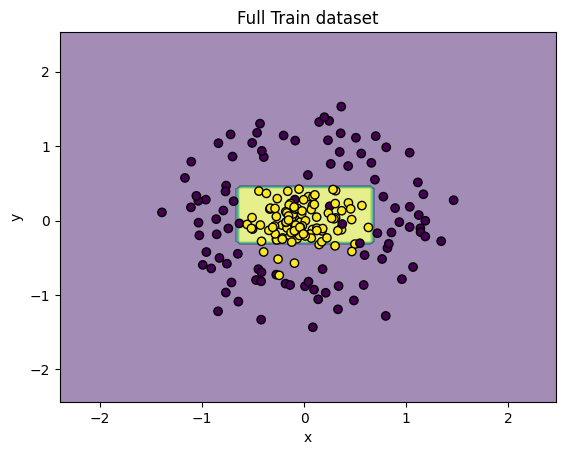

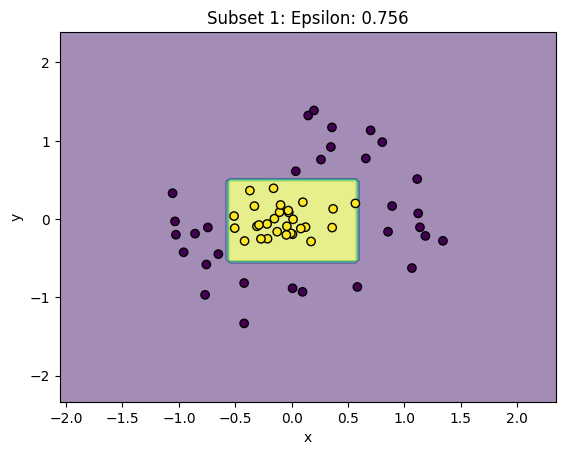

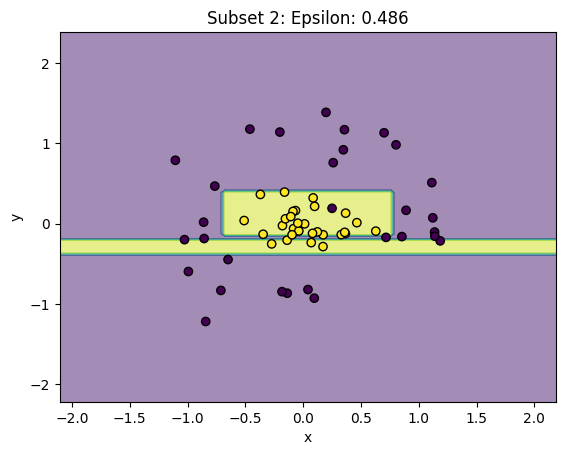

In [7]:
plot_decision_boundaries_within_data(treeC, X, y,"Full Train dataset")
plot_decision_boundaries_within_data(tree1, X1, y1,f"Subset 1: Epsilon: {round(find_epsilon(X_train,y_train,X1,y1),3)}")
plot_decision_boundaries_within_data(tree2, X2 ,y2,f"Subset 2: Epsilon: {round(find_epsilon(X_train,y_train,X2,y2),3)}")

Features importance vectors.

In [8]:
importancesC = treeC.feature_importances_
importances1 = tree1.feature_importances_
importances2 = tree2.feature_importances_
print(importancesC)
print(importances1)
print(importances2)
feature_names=["x","y"]

sorted_indicesC,  sorted_indices1, sorted_indices2= np.argsort(importancesC)[::-1],np.argsort(importances1)[::-1],np.argsort(importances2)[::-1]
sorted_featuresC = [feature_names[i] for i in sorted_indicesC]
sorted_features1 = [feature_names[i] for i in sorted_indices1]
sorted_features2 = [feature_names[i] for i in sorted_indices2]

print("Order of importance of the features:")
print("DT trained with whole Trainig set : ", sorted_featuresC)
print("DT trained with subset 1: ", sorted_features1)
print("DT trained with subset 2: ", sorted_features2)

[0.40406131 0.59593869]
[0.50372208 0.49627792]
[0.24405654 0.75594346]
Order of importance of the features:
DT trained with whole Trainig set :  ['y', 'x']
DT trained with subset 1:  ['x', 'y']
DT trained with subset 2:  ['y', 'x']
